In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


In [2]:
data_split_dir = Path("../data/splits")

# Same preprocessing as validation
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=data_split_dir / "test", transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

classes = test_dataset.classes
num_classes = len(classes)
print(f"✅ Test dataset ready: {len(test_dataset)} images, {num_classes} classes")


✅ Test dataset ready: 5459 images, 38 classes


In [3]:
model = models.resnet50(pretrained=False)  # pretrained=False because we will load our trained weights

# Replace classifier same as training
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, num_classes)
)

# Load weights
model.load_state_dict(torch.load("../models/best_resnet50.pth", map_location=device))
model = model.to(device)
model.eval()
print("✅ Best model loaded for evaluation")


d:\Software\Anaconda\envs\pytorch-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Software\Anaconda\envs\pytorch-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\coder\AppData\Local\Temp\ipykernel_12432\1862975532.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `w

✅ Best model loaded for evaluation


In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall accuracy
accuracy = np.mean(all_preds == all_labels)
print(f"✅ Test Accuracy: {accuracy*100:.2f}%") 


✅ Test Accuracy: 93.72%


In [5]:
# Classfication Report
report = classification_report(all_labels, all_preds, target_names=classes)
print("📊 Classification Report:\n")
print(report)


📊 Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.89      0.93        63
                                 Apple___Black_rot       0.98      0.95      0.97        63
                          Apple___Cedar_apple_rust       0.96      0.96      0.96        28
                                   Apple___healthy       0.99      0.95      0.97       165
                               Blueberry___healthy       0.99      0.97      0.98       151
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       106
                 Cherry_(including_sour)___healthy       0.93      0.98      0.96        87
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.71      0.80        52
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       120
               Corn_(maize)___Northern_Leaf_Blight   

<Figure size 1200x1200 with 0 Axes>

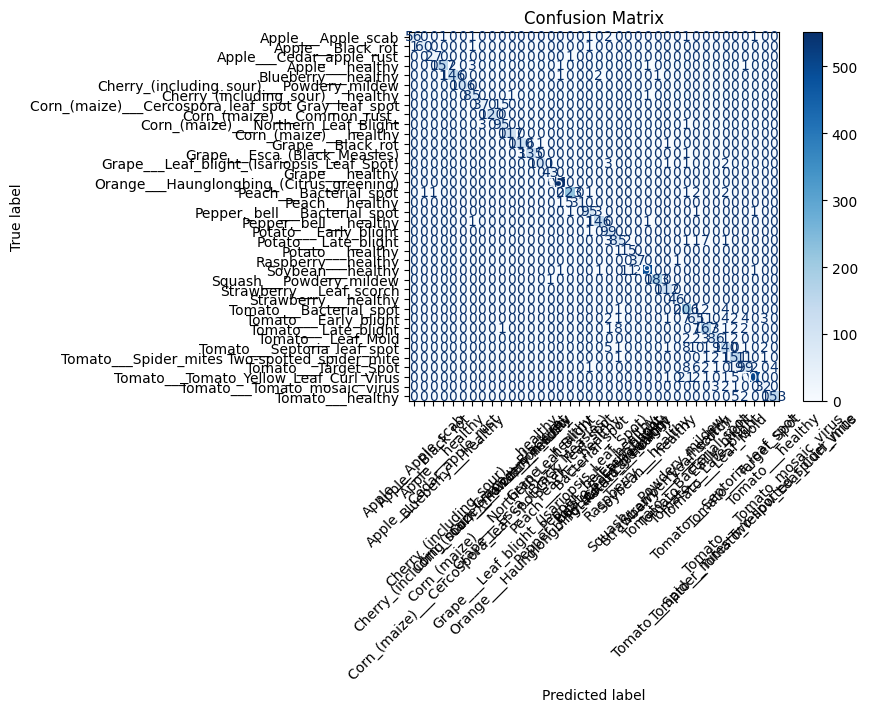

In [6]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(12,12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


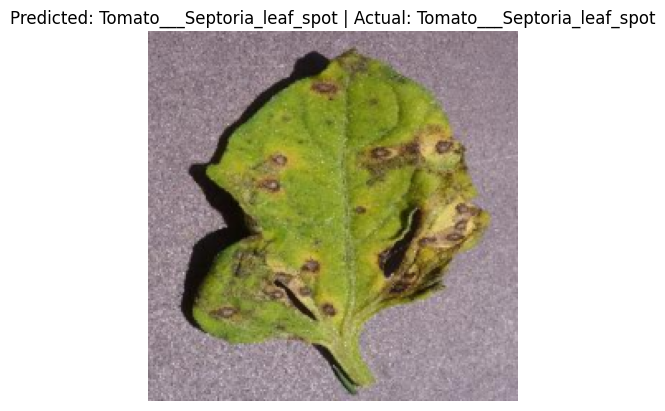

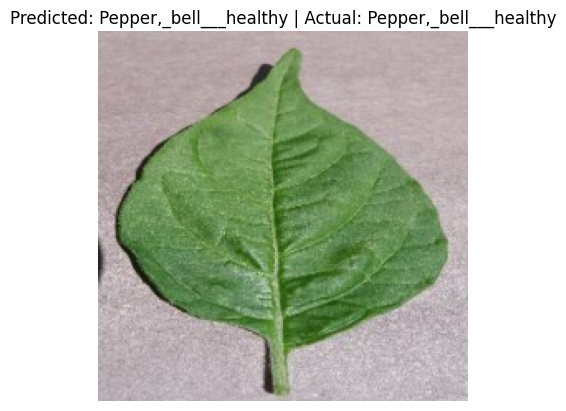

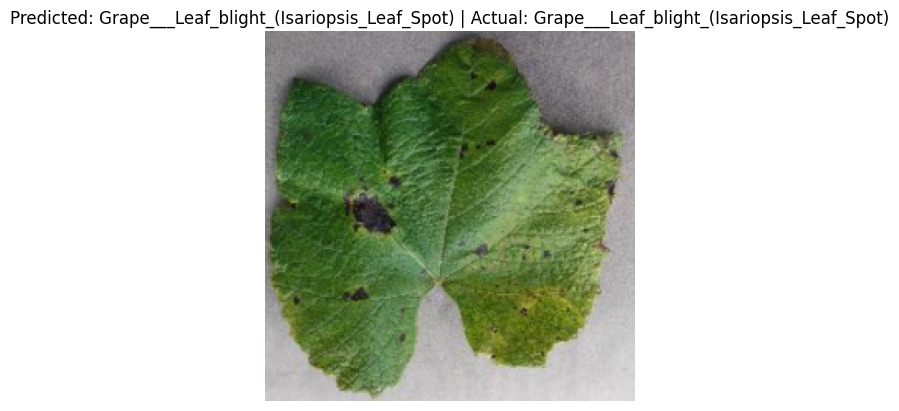

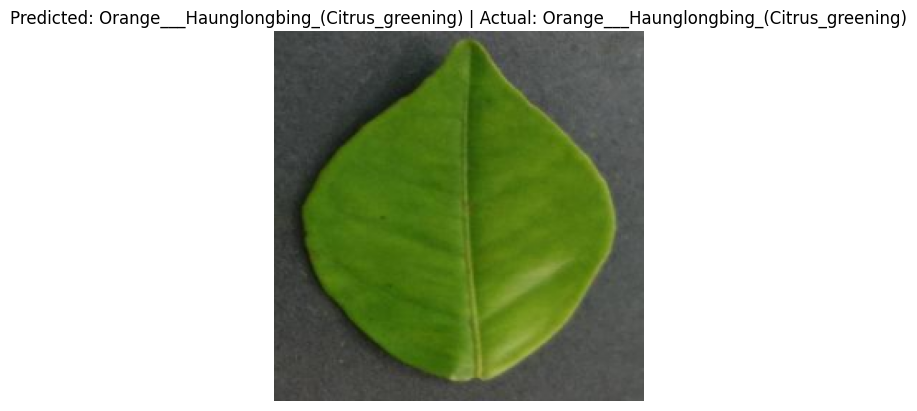

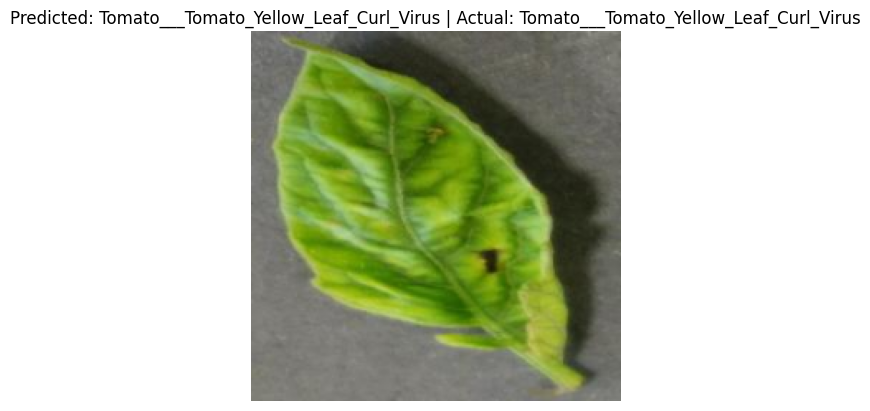

In [7]:
import random
def imshow(img, title=None):
    img = img * torch.tensor([0.229,0.224,0.225]).view(3,1,1) + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    img = torch.clamp(img,0,1)
    np_img = img.numpy().transpose((1,2,0))
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Pick 5 random test images
indices = random.sample(range(len(test_dataset)), 5)
for idx in indices:
    img, label = test_dataset[idx]
    input_img = img.unsqueeze(0).to(device)
    output = model(input_img)
    _, pred = torch.max(output,1)
    imshow(img, title=f"Predicted: {classes[pred.item()]} | Actual: {classes[label]}")
